<a href="https://colab.research.google.com/github/PUBPOL-2130/notebooks/blob/main/future/evictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%config InlineBackend.figure_formats = ["retina"]

In [2]:
!pip install -q folium scikit-learn census seaborn geopandas us

In [3]:
!curl -OL https://raw.githubusercontent.com/PUBPOL-2130/notebooks/main/data/mappluto_subset.gpkg.zip
!unzip mappluto_subset.gpkg.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.0M  100 13.0M    0     0  5074k      0  0:00:02  0:00:02 --:--:-- 5081k
Archive:  mappluto_subset.gpkg.zip
  inflating: mappluto_subset.gpkg    
  inflating: __MACOSX/._mappluto_subset.gpkg  


## Evictions

In [4]:
import census
import folium
import folium.plugins
import geopandas as gpd
import io
import us
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from census import Census
from shapely import Point

In [5]:
census = Census("", year=2018)

We'll start this week with data from the [Eviction Lab](https://evictionlab.org/) at Princeton, home of Matt Desmond and this week's guest Peter Hepburn. This data has been assembled and compiled from multiple sources, and more information on the methods they've used can be found [here](https://evictionlab.org/methods/). It is a powerful resource for studying eviction patterns throughout the United States.

To get a sense of what this data looks like interactively, you can explore their [interactive map](https://evictionlab.org/map).

We'll start with data for estimating eviction prevalence.  Each row is a county in a particular year, from 2000 to 2018.

In [6]:
df_eviction_prev = pd.read_csv(
    "https://eviction-lab-data-downloads.s3.amazonaws.com/estimating-eviction-prevalance-across-us/county_eviction_estimates_2000_2018.csv"
)
df_eviction_prev.head()

state          county  FIPS_state  FIPS_county  year  renting_hh  \
0  Alabama  Autauga County           1         1001  2000        3074   
1  Alabama  Autauga County           1         1001  2001        3264   
2  Alabama  Autauga County           1         1001  2002        3454   
3  Alabama  Autauga County           1         1001  2003        3644   
4  Alabama  Autauga County           1         1001  2004        3834   

   filings_estimate  filings_ci_95_lower  filings_ci_95_upper  \
0               109                  109                  109   
1                75                   75                   75   
2                94                   94                   94   
3               100                  100                  100   
4               112                  112                  112   

   ind_filings_court_issued  ind_filings_court_issued_LT  hh_threat_estimate  \
0                         1                          0.0                 106   
1                         1                          0.0                  74   
2                         1                          0.0                  92   
3                         1                          0.0                  98   
4                         1                          0.0                 110   

   hh_threat_95_lower  hh_threat_95_upper  ind_hht_observed  
0                 106                 106                 1  
1                  71                  75                 0  
2                  88                  94                 0  
3                  94                 100                 0  
4                 106                 112                 0

Next we'll calculate three measures that are common in the eviction literature and that the Eviction Lab reports.  These are a little confusing, so read carefully!

* *Eviction filing rate:* the total number of evictions *filed* per 100 renter-occupied homes in that area for a given year.  Note that this can reflect many filings on one apartment.
* *Households threatened rate:* the total number of renter-occupied households who ever received an eviction filing in a given year, per 100.
* *Eviction judgment rate:* the number of renters who received an eviction judgment/court order requiring them to leave over all renter-occupied homes in a given year.

So suppose there were 100 apartments in all, and 3 of them were filed on 5 times each, and out of those three, two resulted in a court order.  Then the filing rate would be 15, the threatened rate would be 3, and the eviction rate would be 2.  So these numbers should be ordered from largest to smallest.

Also notable:  they give two options for what dataset to use, which they call "Modeled" vs. "Original."  The "original" data comes from proprietary sources -- that means they largely bought it, and it's hard to vouch for the quality.  The "modeled" version uses official court data and smooths it out with some statistical tools.

Filing rate and threatened rate are both available from the modeled data.  Let's look at those first.

In [7]:
df_eviction_prev["filing_rate"] = (
    df_eviction_prev["filings_estimate"] * 100 / df_eviction_prev["renting_hh"]
)
df_eviction_prev["threatened_rate"] = (
    df_eviction_prev["hh_threat_estimate"] * 100 / df_eviction_prev["renting_hh"]
)

In [8]:
df_eviction_prev[["filing_rate", "threatened_rate"]].describe()

filing_rate  threatened_rate
count  59717.000000     59717.000000
mean       5.010749         4.174013
std        7.472987         4.620251
min        0.000000         0.000000
25%        1.381999         1.351351
50%        2.810651         2.698651
75%        5.657193         5.190311
max      154.618193        59.569671

So there was some county that had a filing rate over 150 filings per 100 units -- more than one filing per housing unit! -- in a certain year.

Now we'll summarize this information across all 18 years of data. We'll first sum up the number of filings, threatened households and renting households, and then we'll reproduce our rates.

In [9]:
df_eviction_prev_overall = df_eviction_prev.groupby("FIPS_county")[
    ["filings_estimate", "hh_threat_estimate", "renting_hh"]
].sum()

df_eviction_prev_overall["filing_rate"] = (
    df_eviction_prev_overall["filings_estimate"] * 100 / df_eviction_prev_overall["renting_hh"]
)
df_eviction_prev_overall["threatened_rate"] = (
    df_eviction_prev_overall["hh_threat_estimate"] * 100 / df_eviction_prev_overall["renting_hh"]
)
df_eviction_prev_overall.head()

filings_estimate  hh_threat_estimate  renting_hh  filing_rate  \
FIPS_county                                                                  
1001                     2492                2444       86450     2.882591   
1003                    11869               11531      356720     3.327259   
1005                      529                 529       59900     0.883139   
1007                      522                 520       35274     1.479844   
1009                     1154                1140       76355     1.511361   

             threatened_rate  
FIPS_county                   
1001                2.827068  
1003                3.232507  
1005                0.883139  
1007                1.474174  
1009                1.493026

In [10]:
# load counties shapefiles to map
gdf_counties = gpd.read_file(
    "https://raw.githubusercontent.com/PUBPOL-2130/notebooks/main/data/tl_2018_us_county.zip"
).to_crs(2163)
gdf_counties.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020  None   None     None        A  1477652222  10690952  +41.9158651   
1  G4020  None   None     None        A   680956809  61588406  +46.2946377   
2  G4020  None   None     None        A  6016819484  29089486  +34.3592729   
3  G4020   339  30700     None        A  2169287528  22832516  +40.7835474   
4  G4020  None   None     None        A  1489645187   1718484  +40.1764918   

       INTPTLON                                           geometry  
0  -096.7885168  POLYGON ((246290.041 -328619.667, 246286.51 -3...  
1  -123.4244583  POLYGON ((-1770686.984 398793.664, -1771124.91...  
2  -104.3686961  POLYGON ((-422754.447 -1210188.449, -422784.93...  
3  -096.6886584  POLYGON ((260193.977 -463717.021, 260172 -4631...  
4  -098.0468422  POLYGON ((146978.459 -544334.301, 146978.432 -...

In [11]:
gdf_counties["county_fips_full"] = (
    gdf_counties["STATEFP"] + gdf_counties["COUNTYFP"]
).astype(int)
gdf_counties.set_index("county_fips_full", inplace=True)

In [12]:
gdf_eviction_filings_overall = gdf_counties[
    ["STATEFP", "COUNTYFP", "NAME", "NAMELSAD", "geometry"]
].join(df_eviction_prev_overall, how="left")

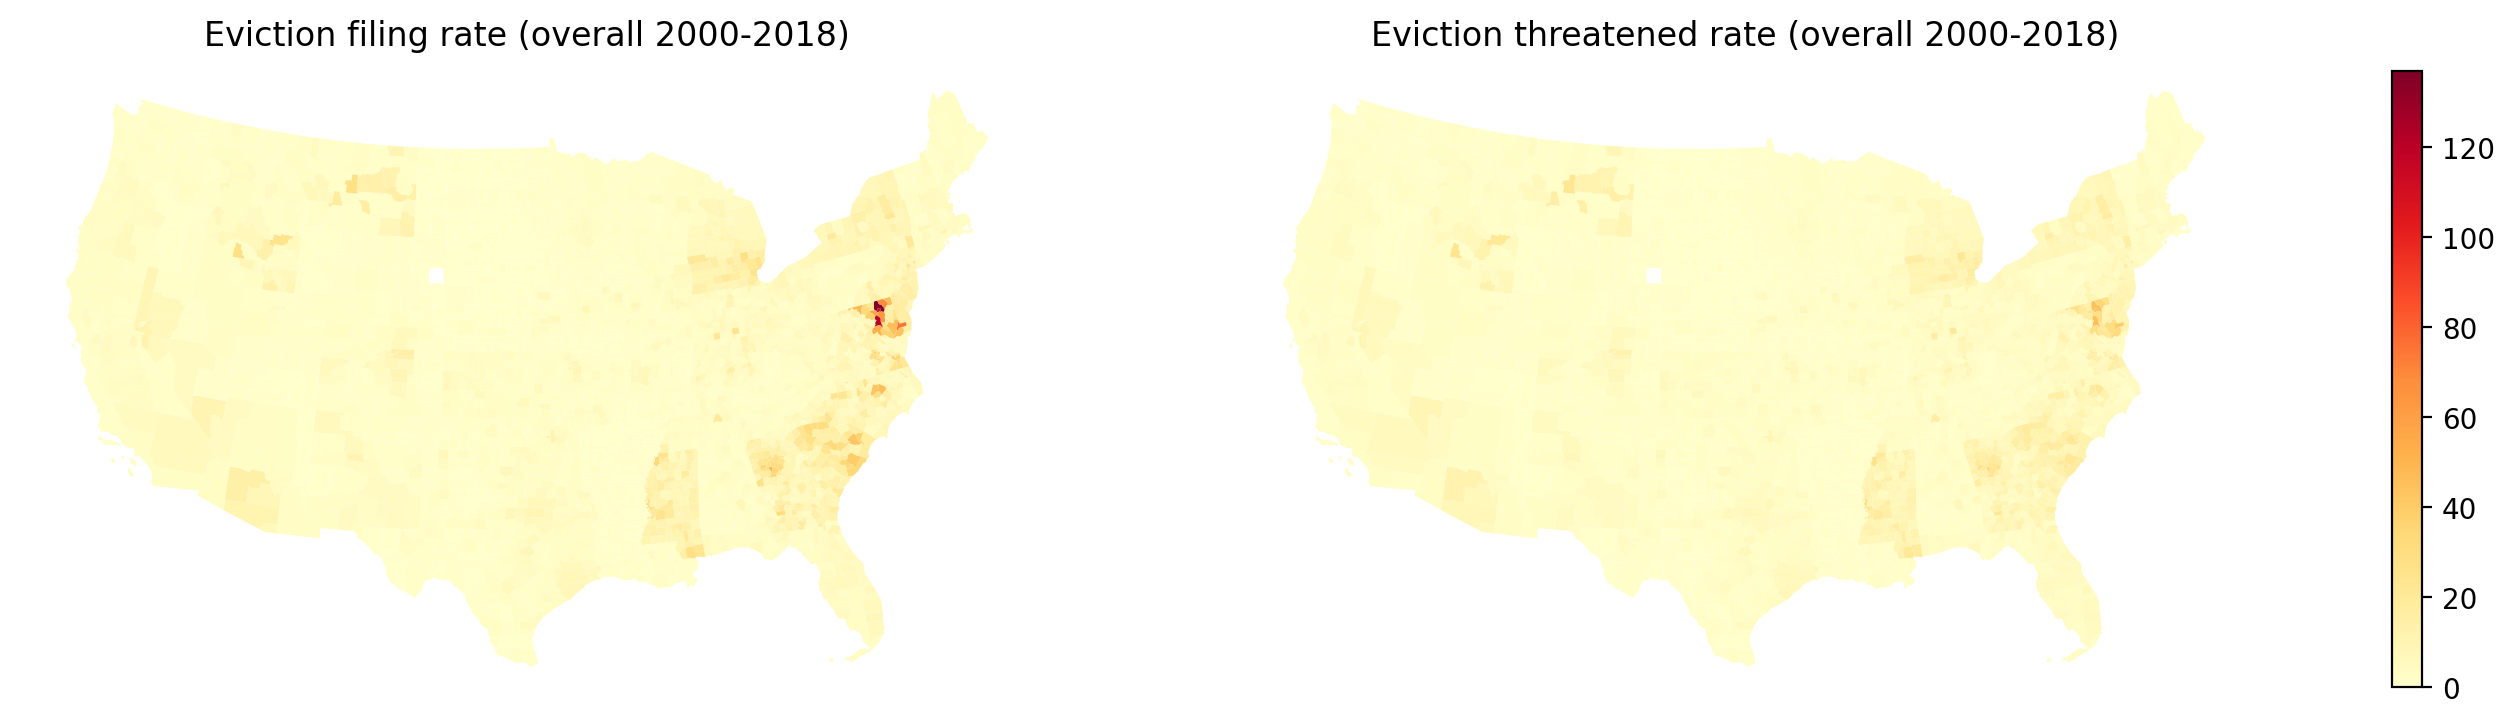

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
# filter out hawaii and alaska for visualization
state_filter = ~gdf_eviction_filings_overall.STATEFP.isin(["15", "02"])
gdf_eviction_filings_overall[state_filter].plot(
    column="filing_rate", ax=axes[0], vmin=0, vmax=137, cmap="YlOrRd", legend=False
)
gdf_eviction_filings_overall[state_filter].plot(
    column="threatened_rate", ax=axes[1], vmin=0, vmax=137, cmap="YlOrRd", legend=False
)
axes[0].set_title("Eviction filing rate (overall 2000-2018)")
axes[1].set_title("Eviction threatened rate (overall 2000-2018)")
axes[0].set_axis_off()
axes[1].set_axis_off()

# assume it's the first (and only) mappable
patch_col = axes[0].collections[0]
cb = fig.colorbar(patch_col, ax=axes, shrink=0.5)

What area had the highest filing rate (and is colored in a dark red in the mid-Atlantic region)?

In [14]:
gdf_eviction_filings_overall[
    gdf_eviction_filings_overall["filing_rate"]
    == gdf_eviction_filings_overall["filing_rate"].max()
]

STATEFP COUNTYFP       NAME          NAMELSAD  \
county_fips_full                                                 
24005                 24      005  Baltimore  Baltimore County   

                                                           geometry  \
county_fips_full                                                      
24005             POLYGON ((1955260.174 -342141.577, 1955257.421...   

                  filings_estimate  hh_threat_estimate  renting_hh  \
county_fips_full                                                     
24005                    2744606.0            885086.0   2014391.0   

                  filing_rate  threatened_rate  
county_fips_full                                
24005              136.249914        43.938143

We can also look at some of the counties with eviction filing rates > 99th percentile.

In [15]:
gdf_eviction_filings_overall[
    gdf_eviction_filings_overall["filing_rate"]
    >= gdf_eviction_filings_overall["filing_rate"].quantile(0.99)
].sort_values("filing_rate", ascending=False)

STATEFP COUNTYFP             NAME                NAMELSAD  \
county_fips_full                                                             
24005                 24      005        Baltimore        Baltimore County   
24033                 24      033  Prince George's  Prince George's County   
24510                 24      510        Baltimore          Baltimore city   
24045                 24      045         Wicomico         Wicomico County   
24025                 24      025          Harford          Harford County   
24003                 24      003     Anne Arundel     Anne Arundel County   
24027                 24      027           Howard           Howard County   
24017                 24      017          Charles          Charles County   
13063                 13      063          Clayton          Clayton County   
24043                 24      043       Washington       Washington County   
37065                 37      065        Edgecombe        Edgecombe County   
24015                 24      015            Cecil            Cecil County   
24019                 24      019       Dorchester       Dorchester County   
51830                 51      830     Williamsburg       Williamsburg city   
24039                 24      039         Somerset         Somerset County   
51730                 51      730       Petersburg         Petersburg city   
45041                 45      041         Florence         Florence County   
37127                 37      127             Nash             Nash County   
45015                 45      015         Berkeley         Berkeley County   
51700                 51      700     Newport News       Newport News city   
51685                 51      685    Manassas Park      Manassas Park city   
24031                 24      031       Montgomery       Montgomery County   
24037                 24      037       St. Mary's       St. Mary's County   
51760                 51      760         Richmond           Richmond city   
45067                 45      067           Marion           Marion County   
51650                 51      650          Hampton            Hampton city   
51580                 51      580        Covington          Covington city   
13151                 13      151            Henry            Henry County   
13255                 13      255         Spalding         Spalding County   
13097                 13      097          Douglas          Douglas County   
45019                 45      019       Charleston       Charleston County   
51678                 51      678        Lexington          Lexington city   

                                                           geometry  \
county_fips_full                                                      
24005             POLYGON ((1955260.174 -342141.577, 1955257.421...   
24033             POLYGON ((1964183.368 -398913.172, 1964168.607...   
24510             POLYGON ((1971826.798 -345975.085, 1971825.144...   
24045             POLYGON ((2072705.275 -430164.685, 2072319.122...   
24025             POLYGON ((1988265.098 -324652.901, 1988253.165...   
24003             POLYGON ((1970416.791 -374960.982, 1970424.931...   
24027             POLYGON ((1948661.073 -368116.611, 1948639.104...   
24017             POLYGON ((1950169.833 -445836.699, 1950169.069...   
13063             POLYGON ((1436807.483 -1134446.214, 1436784.17...   
24043             POLYGON ((1871902.276 -346465.048, 1871901.016...   
37065             POLYGON ((1976150.968 -748814.41, 1976160.311 ...   
24015             POLYGON ((2024273.502 -288695.688, 2024280.154...   
24019             POLYGON ((2054398.136 -406645.683, 2054719.037...   
51830             POLYGON ((2029770.407 -572949.38, 2029769.38 -...   
24039             POLYGON ((2065363.243 -459734.679, 2066257.76 ...   
51730             POLYGON ((1971977.674 -599631.508, 1972074.006...   
45041             POLYGON ((1834594.193 -981941.906, 1834979.423...   
37127          

And we can compute the difference in filing and threatened rates difference between 2018 and 2000, to find out what counties experienced the greatest change in their filing rates over time.

In [16]:
df_eviction_prev.set_index("FIPS_county", inplace=True)
df_eviction_prev_wide = df_eviction_prev[
    df_eviction_prev["year"].isin([2000, 2018])
].pivot(columns="year", values=["threatened_rate", "filing_rate"])
df_eviction_prev_wide.columns = [
    a[0] + "_" + str(a[1]) for a in df_eviction_prev_wide.columns.to_flat_index()
]
df_eviction_prev_wide["filing_rate_diff"] = (
    df_eviction_prev_wide["filing_rate_2018"]
    - df_eviction_prev_wide["filing_rate_2000"]
)
df_eviction_prev_wide["threatened_rate_diff"] = (
    df_eviction_prev_wide["threatened_rate_2018"]
    - df_eviction_prev_wide["threatened_rate_2000"]
)

gdf_eviction_filings_diff = gdf_counties.join(df_eviction_prev_wide)
gdf_eviction_filings_diff.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME  \
county_fips_full                                                
31039                 31      039  00835841  31039     Cuming   
53069                 53      069  01513275  53069  Wahkiakum   
35011                 35      011  00933054  35011    De Baca   
31109                 31      109  00835876  31109  Lancaster   
31129                 31      129  00835886  31129   Nuckolls   

                          NAMELSAD LSAD CLASSFP  MTFCC CSAFP  ...    AWATER  \
county_fips_full                                              ...             
31039                Cuming County   06      H1  G4020  None  ...  10690952   
53069             Wahkiakum County   06      H1  G4020  None  ...  61588406   
35011               De Baca County   06      H1  G4020  None  ...  29089486   
31109             Lancaster County   06      H1  G4020   339  ...  22832516   
31129              Nuckolls County   06      H1  G4020  None  ...   1718484   

                     INTPTLAT      INTPTLON  \
county_fips_full                              
31039             +41.9158651  -096.7885168   
53069             +46.2946377  -123.4244583   
35011             +34.3592729  -104.3686961   
31109             +40.7835474  -096.6886584   
31129             +40.1764918  -098.0468422   

                                                           geometry  \
county_fips_full                                                      
31039             POLYGON ((246290.041 -328619.667, 246286.51 -3...   
53069             POLYGON ((-1770686.984 398793.664, -1771124.91...   
35011             POLYGON ((-422754.447 -1210188.449, -422784.93...   
31109             POLYGON ((260193.977 -463717.021, 260172 -4631...   
31129             POLYGON ((146978.459 -544334.301, 146978.432 -...   

                  threatened_rate_2000 threatened_rate_2018 filing_rate_2000  \
county_fips_full                                                               
31039                         0.177148             0.424448         0.177148   
53069                         0.949367             1.818182         1.265823   
35011                         1.477833             2.429150         1.477833   
31109                         3.260454             3.390461         3.495165   
31129                         0.000000             0.179856         0.000000   

                 filing_rate_2018  filing_rate_diff  threatened_rate_diff  
county_fips_full                                                           
31039                    0.424448          0.247300              0.247300  
53069                    1.818182          0.552359              0.868815  
35011                    2.429150          0.951317              0.951317  
31109                    3.643536          0.148371              0.130008  
31129                    0.179856          0.179856              0.179856  

[5 rows x 24 columns]

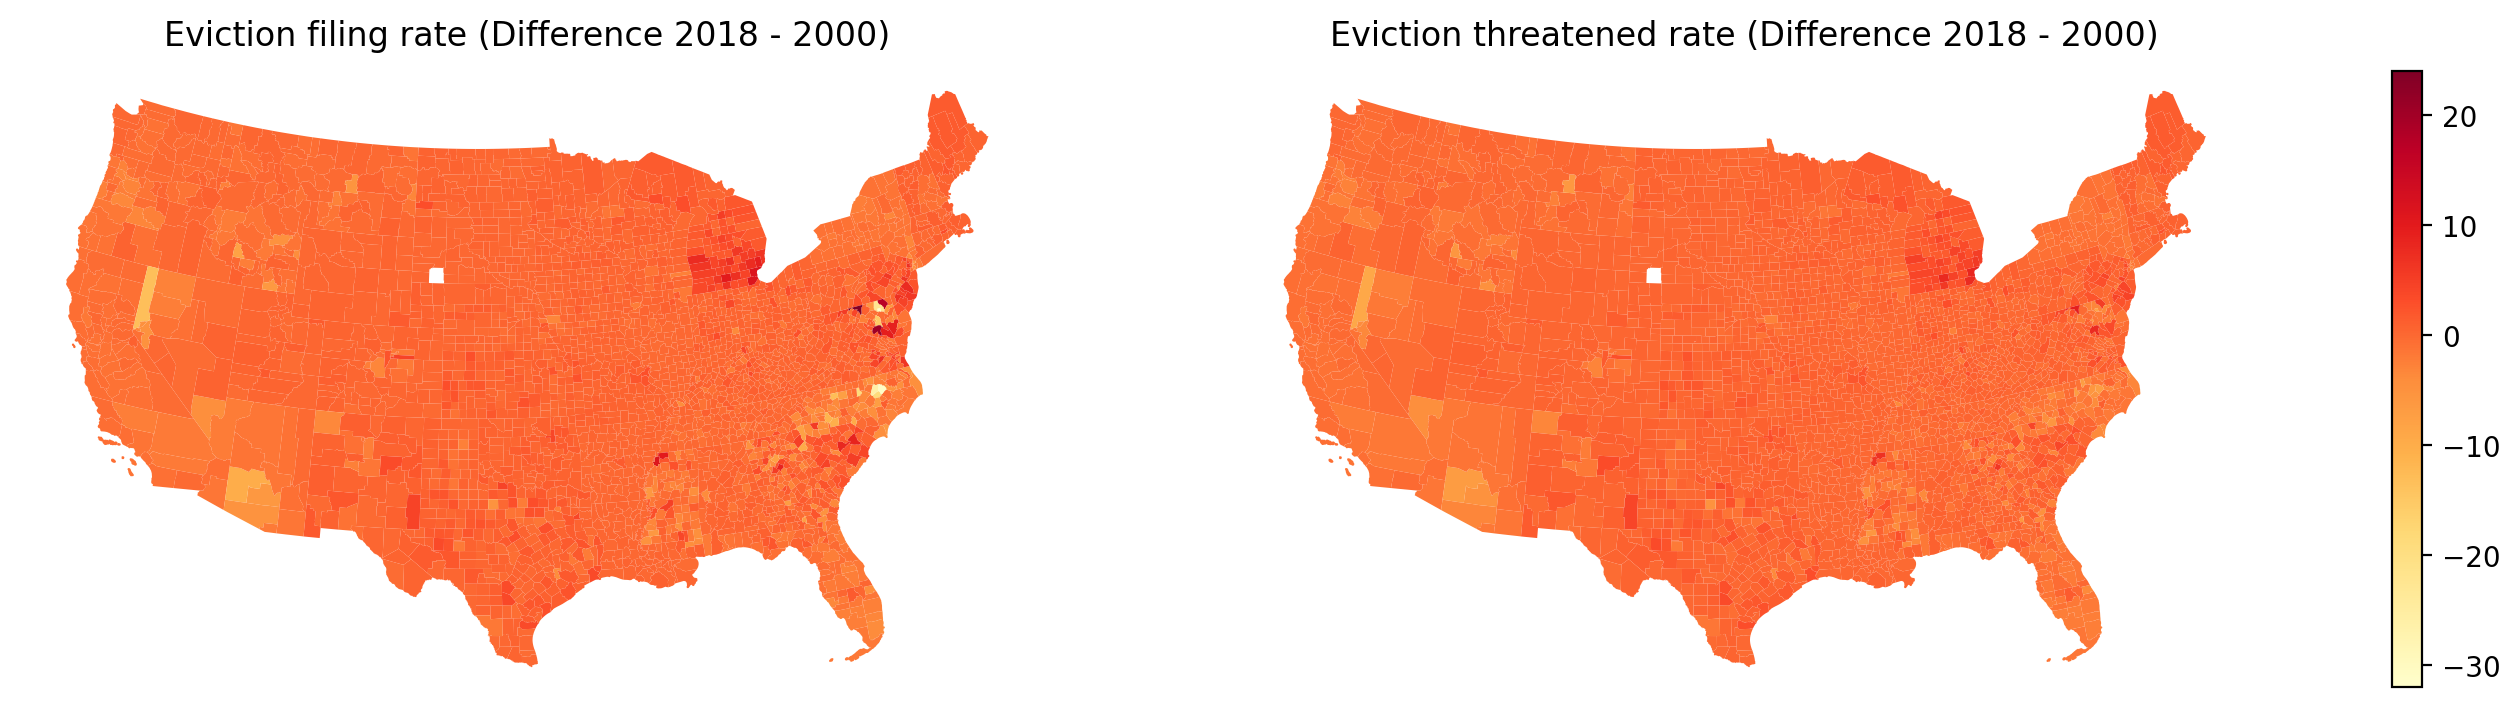

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
# filter out hawaii and alaska for visualization
state_filter = ~gdf_eviction_filings_diff.STATEFP.isin(["15", "02"])
gdf_eviction_filings_diff[state_filter].plot(
    column="filing_rate_diff",
    ax=axes[0],
    vmin=-32,
    vmax=24,
    cmap="YlOrRd",
    legend=False,
)
gdf_eviction_filings_diff[state_filter].plot(
    column="threatened_rate_diff",
    ax=axes[1],
    vmin=-32,
    vmax=24,
    cmap="YlOrRd",
    legend=False,
)
axes[0].set_title("Eviction filing rate (Difference 2018 - 2000)")
axes[1].set_title("Eviction threatened rate (Difference 2018 - 2000)")
axes[0].set_axis_off()
axes[1].set_axis_off()

# assume it's the first (and only) mappable
patch_col = axes[0].collections[0]
cb = fig.colorbar(patch_col, ax=axes, shrink=0.5)

Now we'll explore the proprietary data. The Eviction Lab shares this data on their map, but notes that it has limited coverage and there may be data quality issues. Additionally, these rates have already been produced without denominators, so we'll need to link back to the modeled data to get estimates of renting households.

In [18]:
df_proprietary = pd.read_csv(
    "https://eviction-lab-data-downloads.s3.amazonaws.com/estimating-eviction-prevalance-across-us/county_proprietary_2000_2018.csv"
)
df_proprietary.head()

id            name parent_location  year      type  filings  filing_rate  \
0  1001  Autauga County         Alabama  2000  observed     57.0         1.85   
1  1001  Autauga County         Alabama  2001  observed     84.0         2.73   
2  1001  Autauga County         Alabama  2002  observed    100.0         3.25   
3  1001  Autauga County         Alabama  2003  observed    102.0         3.32   
4  1001  Autauga County         Alabama  2004  observed     19.0         0.62   

   threatened  threatened_rate  judgements  judgement_rate  
0        54.0             1.76        35.0            1.14  
1        83.0             2.70        35.0            1.14  
2        97.0             3.16        20.0            0.65  
3        90.0             2.93        12.0            0.39  
4        19.0             0.62        12.0            0.39

In [19]:
df_proprietary_overall = df_proprietary.merge(df_eviction_prev.reset_index()[["FIPS_county", "year", "renting_hh"]],
                                          left_on=["id", "year"],
                                          right_on = ["FIPS_county", "year"])\
                                          .groupby("id")[["filings", "threatened", "judgements", "renting_hh"]].sum()

df_proprietary_overall["filing_rate"] = (
    df_proprietary_overall["filings"] * 100 / df_proprietary_overall["renting_hh"]
)
df_proprietary_overall["threatened_rate"] = (
    df_proprietary_overall["threatened"] * 100 / df_proprietary_overall["renting_hh"]
)
df_proprietary_overall["judgement_rate"] = (
    df_proprietary_overall["judgements"] * 100 / df_proprietary_overall["renting_hh"]
)
df_proprietary_overall.head()

filings  threatened  judgements  renting_hh  filing_rate  \
id                                                               
1001   2009.0      1903.0      1108.0       86450     2.323887   
1003  10054.0      9739.0      5602.0      356720     2.818457   
1005    481.0       474.0       263.0       59900     0.803005   
1007    314.0       309.0       174.0       35274     0.890174   
1009   1025.0      1008.0       730.0       76355     1.342414   

      threatened_rate  judgement_rate  
id                                     
1001         2.201272        1.281666  
1003         2.730153        1.570419  
1005         0.791319        0.439065  
1007         0.875999        0.493281  
1009         1.320149        0.956061

In [20]:
gdf_proprietary = gdf_counties.join(df_proprietary_overall, how="left")

In [21]:
gdf_proprietary.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'filings', 'threatened',
       'judgements', 'renting_hh', 'filing_rate', 'threatened_rate',
       'judgement_rate'],
      dtype='object')

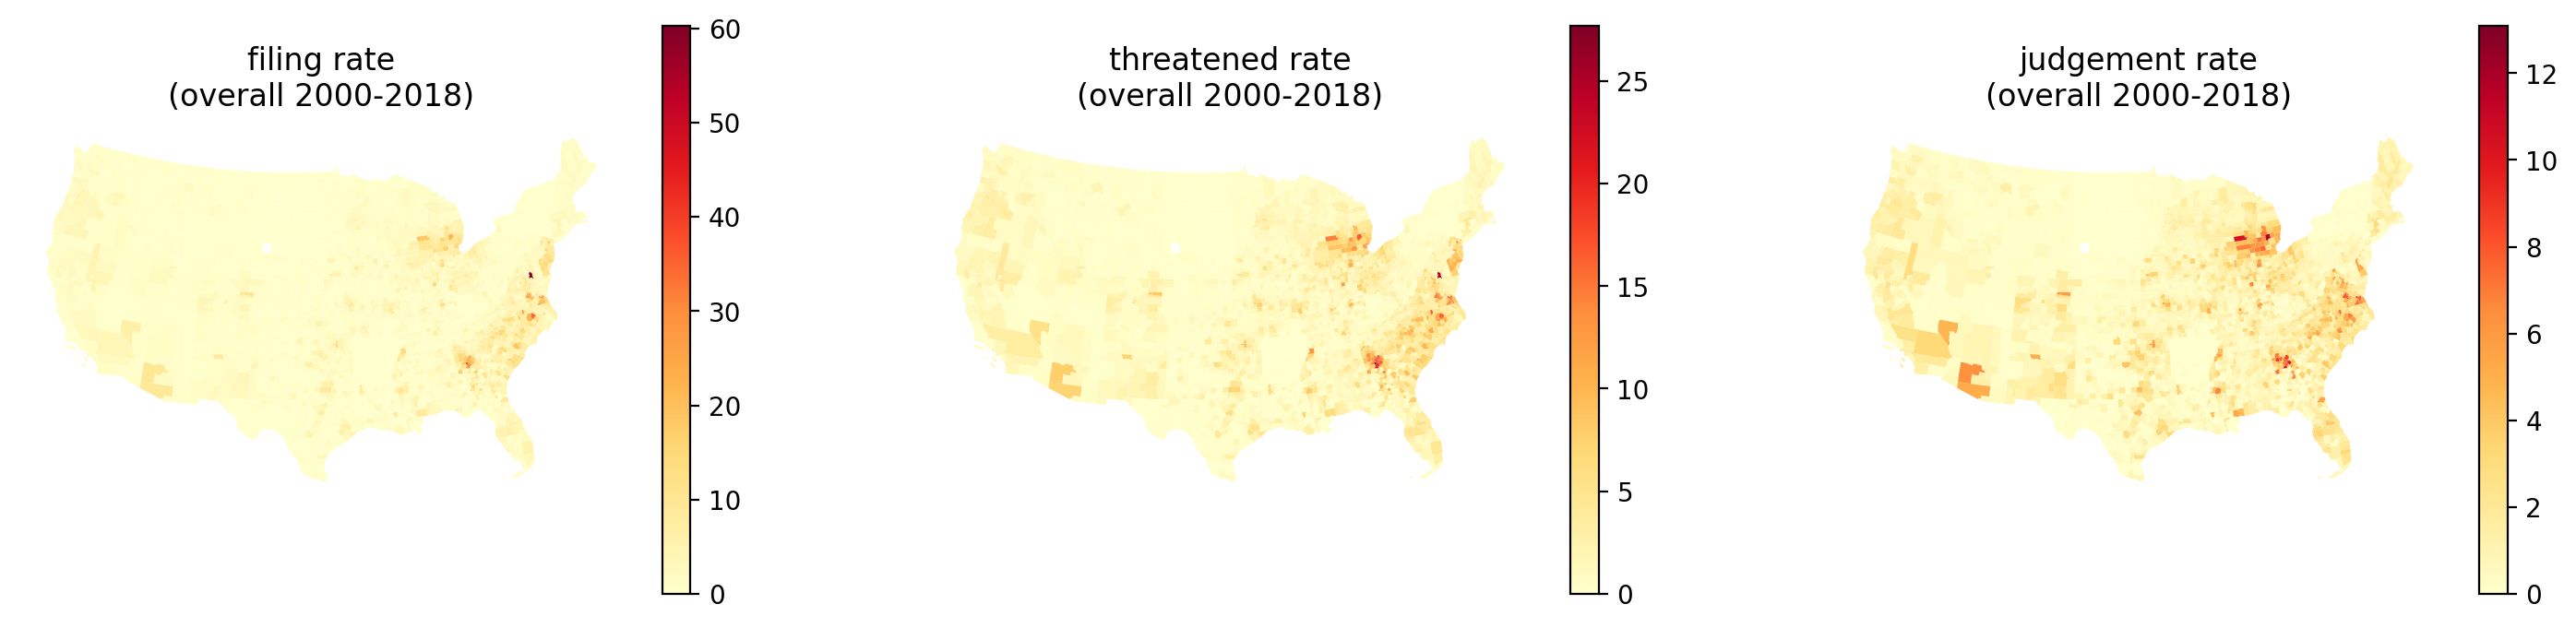

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
# filter out hawaii and alaska for visualization
for i, col in enumerate(["filing_rate", "threatened_rate", "judgement_rate"]):
    state_filter = ~gdf_proprietary.STATEFP.isin(["15", "02"])
    gdf_proprietary[state_filter].plot(
        column=col,
        ax=axes[i],
        cmap="YlOrRd",
        legend=True,
        legend_kwds={"shrink": 0.5},
    )

    axes[i].set_title(f"{col.replace('_',' ')}\n(overall 2000-2018)")
    axes[i].set_axis_off()

Interesting, all of the data for North Dakota is not available!

Let's try comparing the modeled data to the proprietary data. It looks like the proprietary data might be undercounting the eviction filing rates and threatened rates.

In [23]:
df_eviction_mgd = df_eviction_prev.reset_index().merge(
    df_proprietary,
    left_on=["FIPS_county", "year"],
    right_on=["id", "year"],
    suffixes=["_modeled", "_proprietary"],
)

For example, what's happening in Baltimore county?

In [24]:
df_eviction_mgd[df_eviction_mgd["FIPS_county"] == 24005][
    ["year", "filing_rate_modeled", "filing_rate_proprietary"]
]

year  filing_rate_modeled  filing_rate_proprietary
22724  2000           121.373512                     0.03
22725  2001           118.785111                     0.19
22726  2002           125.663771                     0.02
22727  2003           122.091880                     0.02
22728  2004           123.634952                     0.04
22729  2005           125.206232                     0.35
22730  2006           131.876556                     0.63
22731  2007           140.623602                     2.02
22732  2008           141.270577                    71.71
22733  2009           154.618193                    21.37
22734  2010           152.996842                     0.50
22735  2011           143.349094                     0.51
22736  2012           149.131072                     0.49
22737  2013           148.937600                     0.53
22738  2014           142.774334                     0.47
22739  2015           144.284317                     0.04
22740  2016           147.062861                     0.04
22741  2017           151.670335                     0.03
22742  2018            98.783299                     0.03

In [25]:
df_eviction_mgd[df_eviction_mgd["FIPS_county"] == 24005][
    ["year", "threatened_rate_modeled", "threatened_rate_proprietary"]
]

year  threatened_rate_modeled  threatened_rate_proprietary
22724  2000                39.097412                         0.03
22725  2001                36.800465                         0.18
22726  2002                39.235539                         0.02
22727  2003                39.196403                         0.02
22728  2004                43.462503                         0.04
22729  2005                46.355005                         0.33
22730  2006                47.269768                         0.58
22731  2007                46.493822                         1.97
22732  2008                46.983345                        22.98
22733  2009                47.646106                        10.58
22734  2010                48.978544                         0.48
22735  2011                46.926642                         0.48
22736  2012                48.142753                         0.47
22737  2013                47.304046                         0.49
22738  2014                45.143977                         0.45
22739  2015                43.416982                         0.04
22740  2016                42.668879                         0.03
22741  2017                43.659065                         0.03
22742  2018                35.780808                         0.03

This is a **huge** undercount!

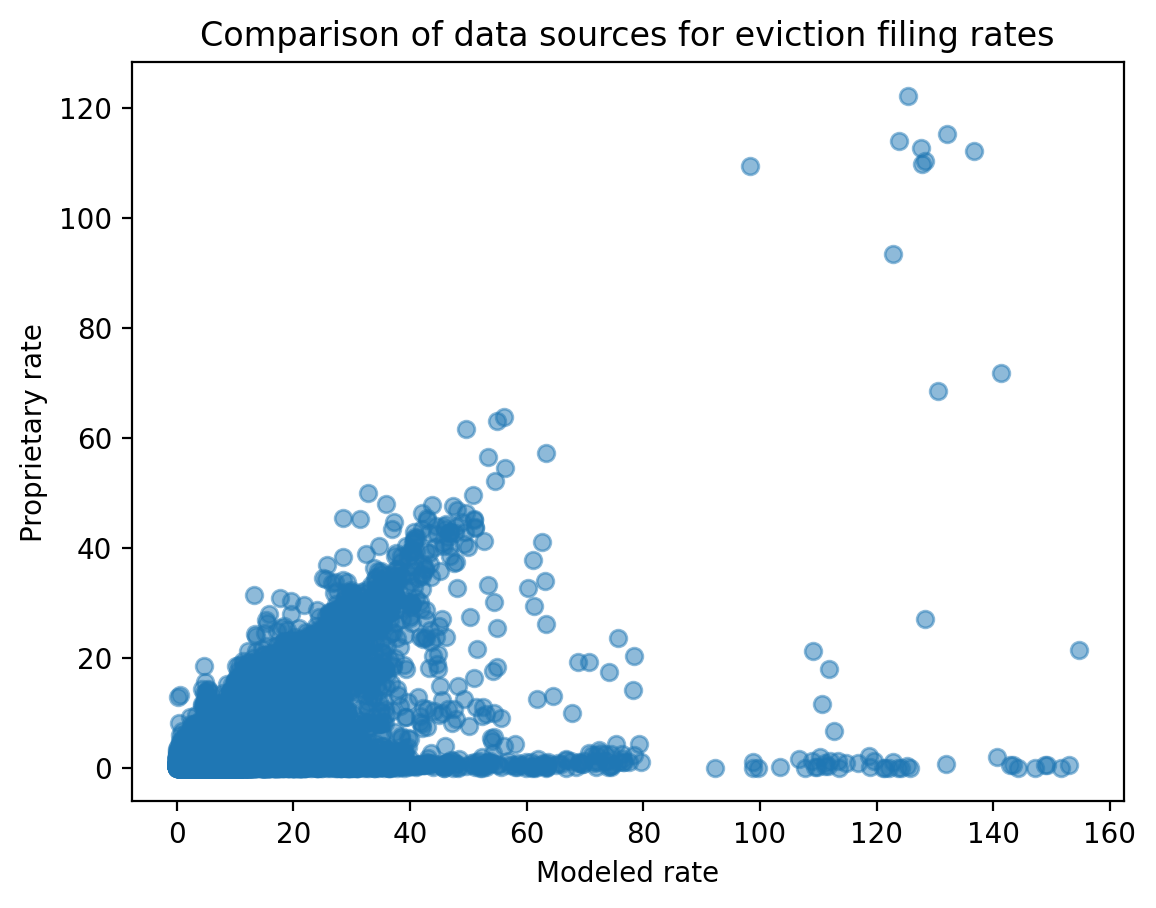

In [26]:
plt.scatter(
    df_eviction_mgd["filing_rate_modeled"],
    df_eviction_mgd["filing_rate_proprietary"],
    alpha=0.5,
)
plt.xlabel("Modeled rate")
plt.ylabel("Proprietary rate")
plt.title("Comparison of data sources for eviction filing rates")
plt.show()

## Comparison to Census Data

Let's load some county level ACS data.

In [27]:
acs_cols = [
    "B02001_001E",
    "B02001_002E",
    "B02001_003E",
    "B02001_004E",
    "B02001_005E",
    "B02001_006E",
    "B02001_007E",
    "B02001_008E",
    "B03002_012E",
    "B25038_001E",
    "B25038_009E",
    "B25031_001E",
]
acs_colnames = [
    "totalpop",
    "white",
    "black",
    "aian",
    "asian",
    "nhpi",
    "other",
    "multi",
    "hispanic_latino",
    "totalhh",
    "renters",
    "median_gross_rent",
]

In [28]:
county_acs_df = pd.DataFrame(
    census.acs5.get(
        tuple(acs_cols),
        geo={
            "for": "county:*",
            "in": "state:*",
        },
        year=2018,
    )
)

KeyboardInterrupt: 

In [ ]:
county_acs_df_clean = county_acs_df.rename(
    columns={x: y for x, y in zip(acs_cols, acs_colnames)}
)
county_acs_df_clean["GEOID10"] = (
    county_acs_df_clean["state"] + county_acs_df_clean["county"]
).astype(int)
county_acs_df_clean.set_index("GEOID10", inplace=True)
county_acs_df_clean.head()

In [ ]:
county_acs_df_clean["renters_pct"] = (
    100 * county_acs_df_clean["renters"] / county_acs_df_clean["totalhh"]
)

race_eth_cols = [
    "white",
    "black",
    "aian",
    "asian",
    "nhpi",
    "other",
    "multi",
    "hispanic_latino",
]
for col in race_eth_cols:
    county_acs_df_clean[col + "_pct"] = (
        100 * county_acs_df_clean[col] / county_acs_df_clean["totalpop"]
    )

Let's merge on the Census ACS data.

In [ ]:
county_acs_df_clean

In [ ]:
gdf_eviction_filings_demo = gdf_eviction_filings_overall.join(county_acs_df_clean)

# let's also set sentinel values for median gross rent
gdf_eviction_filings_demo["median_gross_rent"] = np.where(
    gdf_eviction_filings_demo["median_gross_rent"] < 0,
    np.nan,
    gdf_eviction_filings_demo["median_gross_rent"],
)

In [ ]:
# just exploring a subset of columns
for col in ["renters_pct", "median_gross_rent", "black_pct", "white_pct"]:
    plt.scatter(
        gdf_eviction_filings_demo["filing_rate"],
        gdf_eviction_filings_demo[col],
        alpha=0.5,
    )
    plt.xlabel("eviction filing rate")
    plt.ylabel(col.replace("_", " "))
    plt.title(f"eviction filing rate vs. {col.replace('_', ' ')}")
    plt.show()

## Eviction Data: NYC Open Data

The Eviction Lab provides a comprehensive resource on evictions, but it's not the only resource on evictions. We can also use local data. For example, New York City publishes an [Open Data set](https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4/about_data) on *executed* evictions. This is building level data on evictions going back to 2017.

Eviction data in general is challenging to obtain and often subject to specific state and local policies. For example, the New York State OCA Data Collective receives housing court filings data from the state Office of Court Administration and shares this with local organizations like the [Housing Data Coalition](https://www.housingdatanyc.org/). The OCA Data Collective includes organizations like the Right to Counsel Coalition, BetaNYC, the Association for Neighborhood and Housing Development, the University Neighborhood Housing Program, and JustFix. It is also affiliated with the Housing Data Coalition (HDC). Together, these groups help to make local, deidentified eviction *filing* data available for New York City, often to support tenant advocacy groups and to fight predatory landlords.

A helpful feature of working with local data from NYC is the use of a borough-block-lot identifier, which uniquely identifies every parcel in the city. This makes it very easy to join tabular data (i.e., eviction data) to geospatial data (i.e., parcel data), and allows us to avoid geocoding ourselves.

We'll first load a subset of [MapPLUTO](https://www.nyc.gov/content/planning/pages/resources?search=pluto#datasets), which is the New York City Department of City Planning's geospatial tax lot data. PLUTO stands for the primary land use tax output.

Note: for ease of loading the data, we'll load only a subset of parcels that we know will join to our eviction data.

In [29]:
mppluto = gpd.read_file("mappluto_subset.gpkg")
mppluto.head()

BBL OwnerType LandUse  UnitsTotal  UnitsRes  AssessLand  \
0  1.000078e+09      None      04        43.0      42.0   1741500.0   
1  1.000100e+09      None      05        97.0       0.0   6930000.0   
2  1.000118e+09      None      04         4.0       3.0    363150.0   
3  1.000160e+09         X      05         6.0       0.0  52420950.0   
4  1.000200e+09      None      05        71.0       0.0  11340000.0   

     AssessTot    ExemptTot  YearBuilt  \
0    6970950.0          0.0     1880.0   
1   30483900.0          0.0     1930.0   
2    3464190.0          0.0     1900.0   
3  350676450.0  350676450.0     2009.0   
4   32468850.0          0.0     1983.0   

                                            geometry  
0  MULTIPOLYGON (((981311.209 195510.668, 981240....  
1  MULTIPOLYGON (((980867.809 195627.081, 980872....  
2  MULTIPOLYGON (((980911.184 195813.831, 980911....  
3  MULTIPOLYGON (((980392.176 199856.826, 980381....  
4  MULTIPOLYGON (((980678.427 196676.025, 980634....

In [30]:
mppluto.columns

Index(['BBL', 'OwnerType', 'LandUse', 'UnitsTotal', 'UnitsRes', 'AssessLand',
       'AssessTot', 'ExemptTot', 'YearBuilt', 'geometry'],
      dtype='object')

In [31]:
mppluto["BBL"].unique().shape, mppluto["BBL"].shape

((40536,), (40536,))

Now we'll load our eviction data from NYC Open Data.

In [55]:
df_nyc_evictions = pd.read_csv(
    "https://data.cityofnewyork.us/resource/6z8x-wfk4.csv?$limit=1000000"
)

In [56]:
df_nyc_evictions.head()

court_index_number  docket_number             eviction_address  \
0           65811/19          11596     879 LENOX ROAD APT. #B-1   
1          309512/23         124542              2107 DIX AVENUE   
2           80299/17         295210  169 54TH STREET    SUITE#20   
3          300164/22         360960          323 WEST 4TH STREET   
4          R51007/19          97085            8 TOWNSEND AVENUE   

  eviction_apt_num            executed_date marshal_first_name  \
0              B-1  2019-09-19T00:00:00.000             Robert   
1                2  2024-06-05T00:00:00.000             Justin   
2              NaN  2017-11-30T00:00:00.000             George   
3               4D  2022-04-13T00:00:00.000             Thomas   
4              NaN  2019-07-29T00:00:00.000             Ileana   

  marshal_last_name residential_commercial_ind        borough  eviction_zip  \
0          Renzulli                Residential       BROOKLYN         11203   
1          Grossman                Residential         QUEENS         11691   
2            Essock                 Commercial       BROOKLYN         11220   
3               Bia                Residential      MANHATTAN         10014   
4            Rivera                Residential  STATEN ISLAND         10304   

          ejectment eviction_possession   latitude  longitude  \
0  Not an Ejectment          Possession  40.655593 -73.926748   
1  Not an Ejectment          Possession  40.606213 -73.753921   
2  Not an Ejectment          Possession  40.647345 -74.020050   
3  Not an Ejectment          Possession  40.737693 -74.003857   
4  Not an Ejectment          Possession  40.621067 -74.072231   

   community_board  council_district  census_tract        bin           bbl  \
0             17.0              41.0         866.0  3100953.0  3.046410e+09   
1             14.0              31.0      103201.0  4532717.0  4.155280e+09   
2              7.0              38.0          18.0  3014135.0  3.008120e+09   
3              2.0               3.0          77.0  1011033.0  1.006150e+09   
4              1.0              49.0          40.0  5131331.0  5.028400e+09   

                             nta  
0           Rugby-Remsen Village  
1         Far Rockaway-Bayswater  
2               Sunset Park West  
3                   West Village  
4  Grymes Hill-Clifton-Fox Hills

You may realize that the eviction data has duplicates. It has perfect duplicates (entire rows of data that are duplicated), and there are also instances of multiple rows for the same address on the same day. There are also instances of missing BBLs!

In [57]:
# example of perfect duplicates, let's drop those
print(df_nyc_evictions.drop_duplicates().shape, df_nyc_evictions.shape)
df_nyc_evictions = df_nyc_evictions.drop_duplicates()

(107255, 20) (107435, 20)


In [58]:
# we'll reformat the date, to remove time
df_nyc_evictions.loc[:,'executed_date_only'] = pd.to_datetime(df_nyc_evictions.loc[:,'executed_date'])

<ipython-input-58-e008bc0868ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc_evictions.loc[:,'executed_date_only'] = pd.to_datetime(df_nyc_evictions.loc[:,'executed_date'])


In [59]:
unique_vars = ['eviction_address', 'marshal_first_name', 'marshal_last_name', 'executed_date_only']
df_nyc_evictions[df_nyc_evictions.duplicated(subset=unique_vars, keep=False)].sort_values(unique_vars)

court_index_number  docket_number  \
24935            81013/18           9981   
88562            81013/18           9967   
1210             56990/19          10787   
19811            56990/19          11293   
30707            74747/19         104780   
...                   ...            ...   
88232          316069/22A         121332   
31645          311508/22A         109600   
70787          311508/22B         109601   
36345           29257/17A          71453   
103711          29257/17B          71593   

                                        eviction_address eviction_apt_num  \
24935   (AVALON FORT GREENE)  343 GOLD STREET - APT 3309             3309   
88562   (AVALON FORT GREENE)  343 GOLD STREET - APT 3309             3309   
1210       (THE BUCHANAN) 160 EAST 48TH STREET - APT #3P              #3P   
19811      (THE BUCHANAN) 160 EAST 48TH STREET - APT #3P              #3P   
30707           1 ARDEN STREET   A/K /A 128 NAGLE AVENUE              405   
...                                                  ...              ...   
88232                                998 BUSHWICK AVENUE               4L   
31645                                   998 GRANT AVENUE        1ST FLOOR   
70787                                   998 GRANT AVENUE        1ST FLOOR   
36345                                  999 EAST 163RD ST               2B   
103711                                 999 EAST 163RD ST               2B   

                  executed_date marshal_first_name marshal_last_name  \
24935   2019-03-29T00:00:00.000             Robert          Renzulli   
88562   2019-03-29T00:00:00.000             Robert          Renzulli   
1210    2019-06-21T00:00:00.000             Robert          Renzulli   
19811   2019-06-21T00:00:00.000             Robert          Renzulli   
30707   2020-03-03T00:00:00.000             Justin          Grossman   
...                         ...                ...               ...   
88232   2023-09-06T00:00:00.000             Justin          Grossman   
31645   2022-11-09T00:00:00.000             Justin          Grossman   
70787   2022-11-09T00:00:00.000             Justin          Grossman   
36345   2017-12-07T00:00:00.000             Justin          Grossman   
103711  2017-12-07T00:00:00.000             Justin          Grossman   

       residential_commercial_ind    borough  eviction_zip  ...  \
24935                 Residential   BROOKLYN         11201  ...   
88562                 Residential   BROOKLYN         11201  ...   
1210                  Residential  MANHATTAN         10017  ...   
19811                 Residential  MANHATTAN         10017  ...   
30707                 Residential  MANHATTAN         10040  ...   
...                           ...        ...           ...  ...   
88232                 Residential   BROOKLYN         11221  ...   
31645                 Residential      BRONX         10456  ...   
70787                 Residential      BRONX         10456  ...   
36345                 Residential      BRONX         10459  ...   
103711                Residential      BRONX         10459  ...   

       eviction_possession   latitude  longitude  community_board  \
24935           Possession        NaN        NaN              NaN   
88562           Possession        NaN        NaN              NaN   
1210            Possession        NaN        NaN              NaN   
19811           Possession        NaN        NaN              NaN   
30707           Possession  40.861257 -73.926684             12.0   
...                    ...        ...        ...              ...   
88232           Possession  40.691876 -73.922337              4.0   
31645           Possession  40.829091 -73.917595              4.0   
70787           Possession  40.829091 -73.917595              4.0   
36345           Possession  40.820985 -73.893315              2.0   
103711          Possession  40.820985 -73.893315              2.0   

        council_district  census_tract        bin     

We'll make the simplifying assumption that each of these duplicate rows represents a single eviction. We also won't explore missing BBL values, but in a more comprehensive analysis, you could try geocoding these yourself using a tool from NYC Department of City Planning [Geoclient](https://maps.nyc.gov/geoclient/v1/doc).

In [60]:
df_nyc_evictions_dedup = df_nyc_evictions.drop_duplicates(
    subset=['eviction_address', 'eviction_apt_num', 'marshal_first_name', 'marshal_last_name',
                  'residential_commercial_ind', 'borough', 'eviction_zip', 'ejectment', 'eviction_possession',
                  'latitude', 'longitude', 'community_board', 'council_district', 'census_tract', 'bin', 'bbl','nta',
                  'executed_date_only'],
    keep='first')

In [61]:
df_nyc_evictions_dedup.shape

(97809, 21)

Now we'll merge the two datasets together. Notice: we can merge on BBL, which is might simpler than geocoding and doing a spatial join.

In [62]:
nyc_evictions_pluto = mppluto[
    [
        "BBL",
        "OwnerType",
        "LandUse",
        "UnitsTotal",
        "UnitsRes",
        "AssessLand",
        "AssessTot",
        "ExemptTot",
        "YearBuilt",
        "geometry",
    ]
].merge(df_nyc_evictions, left_on="BBL", right_on="bbl")

In [63]:
# create a version that's point data using centroid
nyc_evictions_pluto_centroid = nyc_evictions_pluto.copy()
nyc_evictions_pluto_centroid["geometry"] = nyc_evictions_pluto_centroid[
    "geometry"
].centroid

In [64]:
nyc_evictions_pluto_centroid

BBL OwnerType LandUse  UnitsTotal  UnitsRes  AssessLand  \
0      1.000078e+09      None      04        43.0      42.0   1741500.0   
1      1.000078e+09      None      04        43.0      42.0   1741500.0   
2      1.000100e+09      None      05        97.0       0.0   6930000.0   
3      1.000118e+09      None      04         4.0       3.0    363150.0   
4      1.000160e+09         X      05         6.0       0.0  52420950.0   
...             ...       ...     ...         ...       ...         ...   
96560  5.080200e+09      None      01         2.0       2.0      9360.0   
96561  5.080200e+09      None      01         2.0       2.0      9360.0   
96562  5.080280e+09      None      01         2.0       2.0      5280.0   
96563  5.080280e+09      None      01         2.0       2.0      5280.0   
96564  5.080480e+09      None      01         2.0       2.0      6540.0   

         AssessTot    ExemptTot  YearBuilt                       geometry  \
0        6970950.0          0.0     1880.0  POINT (981261.765 195554.133)   
1        6970950.0          0.0     1880.0  POINT (981261.765 195554.133)   
2       30483900.0          0.0     1930.0  POINT (980936.841 195692.534)   
3        3464190.0          0.0     1900.0  POINT (980899.252 195838.209)   
4      350676450.0  350676450.0     2009.0   POINT (980246.708 199670.73)   
...            ...          ...        ...                            ...   
96560      48180.0          0.0     2001.0   POINT (917315.693 127550.54)   
96561      48180.0          0.0     2001.0   POINT (917315.693 127550.54)   
96562      33660.0          0.0     2005.0  POINT (914945.422 125603.509)   
96563      33660.0          0.0     2005.0  POINT (914945.422 125603.509)   
96564      36000.0          0.0     1997.0  POINT (915308.709 125135.319)   

       ... eviction_possession   latitude  longitude community_board  \
0      ...          Possession  40.703611 -74.010932             1.0   
1      ...          Possession  40.703611 -74.010932             1.0   
2      ...          Possession  40.703954 -74.011592             1.0   
3      ...          Possession  40.704034 -74.012068             1.0   
4      ...          Possession  40.713846 -74.013812             1.0   
...    ...                 ...        ...        ...             ...   
96560  ...          Possession  40.516716 -74.240628             3.0   
96561  ...          Possession  40.516716 -74.240628             3.0   
96562  ...          Possession  40.511220 -74.248970             3.0   
96563  ...          Possession  40.511220 -74.248970             3.0   
96564  ...          Possession  40.509789 -74.248069             3.0   

      council_district census_tract        bin           bbl  \
0                  1.0          9.0  1077806.0  1.000078e+09   
1                  1.0          9.0  1077806.0  1.000078e+09   
2                  1.0          9.0  1000025.0  1.000100e+09   
3                  1.0          9.0  1000040.0  1.000118e+09   
4                  1.0      31703.0  1087239.0  1.000160e+09   
...                ...          ...        ...           ...   
96560             51.0        248.0  5129474.0  5.080200e+09   
96561             51.0        248.0  5129474.0  5.080200e+09   
96562             51.0        248.0  5146458.0  5.080280e+09   
96563             51.0        248.0  5146458.0  5.080280e+09   
96564             51.0        248.0  5149821.0  5.080480e+09   

                                          nta  executed_date_only  
0           Battery Park City-Lower Manhattan          2018-05-24  
1           Battery Park City-Lower Manhattan          2023-05-25  
2           Battery Park City-Lower Manhattan          2025-02-27  
3           Battery Park City-Lower Manhattan          2017-07-18  
4           Battery Park City-Lower Manhattan          2018-06-13  
...                                       ...                 ...  
96560  Charleston-Richmond Valley-Tottenville          2023-06-05  
96561  Charl

In [65]:
building_eviction_count = (
    nyc_evictions_pluto.value_counts("BBL")
    .reset_index()
    .rename(columns={"count": "total_num_evictions"})
)
nyc_evictions_pluto = nyc_evictions_pluto.merge(building_eviction_count, on="BBL")
nyc_evictions_pluto.head()

BBL OwnerType LandUse  UnitsTotal  UnitsRes  AssessLand  \
0  1.000078e+09      None      04        43.0      42.0   1741500.0   
1  1.000078e+09      None      04        43.0      42.0   1741500.0   
2  1.000100e+09      None      05        97.0       0.0   6930000.0   
3  1.000118e+09      None      04         4.0       3.0    363150.0   
4  1.000160e+09         X      05         6.0       0.0  52420950.0   

     AssessTot    ExemptTot  YearBuilt  \
0    6970950.0          0.0     1880.0   
1    6970950.0          0.0     1880.0   
2   30483900.0          0.0     1930.0   
3    3464190.0          0.0     1900.0   
4  350676450.0  350676450.0     2009.0   

                                            geometry  ...   latitude  \
0  MULTIPOLYGON (((981311.209 195510.668, 981240....  ...  40.703611   
1  MULTIPOLYGON (((981311.209 195510.668, 981240....  ...  40.703611   
2  MULTIPOLYGON (((980867.809 195627.081, 980872....  ...  40.703954   
3  MULTIPOLYGON (((980911.184 195813.831, 980911....  ...  40.704034   
4  MULTIPOLYGON (((980392.176 199856.826, 980381....  ...  40.713846   

   longitude community_board council_district census_tract        bin  \
0 -74.010932             1.0              1.0          9.0  1077806.0   
1 -74.010932             1.0              1.0          9.0  1077806.0   
2 -74.011592             1.0              1.0          9.0  1000025.0   
3 -74.012068             1.0              1.0          9.0  1000040.0   
4 -74.013812             1.0              1.0      31703.0  1087239.0   

            bbl                                nta executed_date_only  \
0  1.000078e+09  Battery Park City-Lower Manhattan         2018-05-24   
1  1.000078e+09  Battery Park City-Lower Manhattan         2023-05-25   
2  1.000100e+09  Battery Park City-Lower Manhattan         2025-02-27   
3  1.000118e+09  Battery Park City-Lower Manhattan         2017-07-18   
4  1.000160e+09  Battery Park City-Lower Manhattan         2018-06-13   

   total_num_evictions  
0                    2  
1                    2  
2                    1  
3                    1  
4                    1  

[5 rows x 32 columns]

In [66]:
nyc_evictions_pluto[["UnitsRes", "total_num_evictions"]]

UnitsRes  total_num_evictions
0          42.0                    2
1          42.0                    2
2           0.0                    1
3           3.0                    1
4           0.0                    1
...         ...                  ...
96560       2.0                    2
96561       2.0                    2
96562       2.0                    2
96563       2.0                    2
96564       2.0                    1

[96565 rows x 2 columns]

In [67]:
# let's compute a building level rate
nyc_evictions_pluto["eviction_rate_bldg"] = (
    nyc_evictions_pluto["total_num_evictions"] / nyc_evictions_pluto["UnitsTotal"]
)
nyc_evictions_pluto["eviction_rate_bldg"] = np.where(
    nyc_evictions_pluto["UnitsTotal"] == 0,
    np.nan,
    nyc_evictions_pluto["eviction_rate_bldg"],
)
nyc_evictions_pluto["eviction_rate_bldg"].describe()

count    96315.000000
mean         0.449822
std          2.282626
min          0.000103
25%          0.063107
50%          0.148148
75%          0.357143
max         68.000000
Name: eviction_rate_bldg, dtype: float64

Notice, there are some cases where the total number of units is 0, and so our building eviction rate is missing. It's possible that the number of building units changed over time, or the data has been collected incorrectly. We'll just set these cases to missing, but it's worth investigating for a more in depth analysis.

In [68]:
print(nyc_evictions_pluto["eviction_rate_bldg"].isna().mean())
nyc_evictions_pluto[nyc_evictions_pluto["eviction_rate_bldg"].isna()]

0.0025889297364469527


BBL OwnerType LandUse  UnitsTotal  UnitsRes  AssessLand  \
236    1.000240e+09         P      05         0.0       0.0  20160000.0   
412    1.002000e+09      None      05         0.0       0.0    684000.0   
435    1.001620e+09      None      11         0.0       0.0    445050.0   
1643   1.006320e+09      None      11         0.0       0.0    596250.0   
2005   1.004850e+09      None      10         0.0       0.0    192600.0   
...             ...       ...     ...         ...       ...         ...   
95645  5.001950e+09      None      10         0.0       0.0     50400.0   
95694  5.002290e+09      None      11         0.0       0.0     80550.0   
95882  5.008780e+09      None    None         0.0       0.0    117000.0   
95930  5.011270e+09      None      10         0.0       0.0     11760.0   
96537  5.073110e+09      None      11         0.0       0.0     29250.0   

        AssessTot  ExemptTot  YearBuilt  \
236    96930000.0        0.0     1961.0   
412     1585800.0        0.0     1951.0   
435      445050.0        0.0        0.0   
1643     596250.0        0.0        0.0   
2005     192600.0        0.0        0.0   
...           ...        ...        ...   
95645     50400.0        0.0        0.0   
95694     80550.0        0.0        0.0   
95882    219150.0        0.0        0.0   
95930     13680.0        0.0        0.0   
96537     29250.0        0.0        0.0   

                                                geometry  ...  longitude  \
236    MULTIPOLYGON (((980921.36 196349.247, 981044.0...  ... -74.011502   
412    MULTIPOLYGON (((984734.775 200383.457, 984757....  ... -73.997947   
435    MULTIPOLYGON (((984674.558 199465.527, 984698....  ... -73.998092   
1643   MULTIPOLYGON (((981990.872 206807.111, 981988....  ... -74.008476   
2005   MULTIPOLYGON (((984203.404 202638.627, 984190....  ... -74.000144   
...                                                  ...  ...        ...   
95645  MULTIPOLYGON (((950885.543 171291.553, 950783....  ... -74.120695   
95694  MULTIPOLYGON (((950006.271 168601.619, 949983....  ... -74.123401   
95882  MULTIPOLYGON (((954219.502 158356.556, 954192....  ... -74.108682   
95930  MULTIPOLYGON (((943734.599 169698.832, 943727....  ... -74.146476   
96537  MULTIPOLYGON (((919286.186 135654.909, 919325....  ... -74.236698   

       community_board council_district census_tract        bin           bbl  \
236                1.0              1.0          9.0  1000817.0  1.000240e+09   
412                3.0              1.0         29.0  1002391.0  1.002000e+09   
435                3.0              1.0         29.0  1001708.0  1.001620e+09   
1643               2.0              3.0         75.0  1000000.0  1.006320e+09   
2005               2.0              1.0         49.0  1000000.0  1.004850e+09   
...                ...              ...          ...        ...           ...   
95645              1.0             49.0      13302.0  5000000.0  5.001950e+09   
95694              1.0             49.0        141.0  5000000.0  5.002290e+09   
95882              2.0             50.0        177.0  5154780.0  5.008780e+09   
95930              1.0             49.0        213.0  5026205.0  5.011270e+09   
96537              3.0             51.0        226.0  5000000.0  5.073110e+09   

                                                     nta executed_date_only  \
236                    Battery Park City-Lower Manhattan         2017-06-29   
412                                            Chinatown         2017-01-26   
435                                            Chinatown         2018-02-27   
1643                                        West Village         2017-01-24   
2005              SoHo-TriBeCa-Civic Center-Little Italy         2025-03-20   
...                                                  ...                ...   
95645          West New Brighton-New Brighton-St. George         2024-01-10   
95694          West New Brighton-New Brighton-St. George         2025-02-13   
9

We'll subset to nonmissing eviction rates.

In [69]:
nyc_evictions_pluto = nyc_evictions_pluto[
    nyc_evictions_pluto["eviction_rate_bldg"].notna()
]

In [70]:
nyc_evictions_pluto["eviction_rate_bldg"].min(), nyc_evictions_pluto[
    "eviction_rate_bldg"
].max(), nyc_evictions_pluto["eviction_rate_bldg"].quantile(0.95)

(0.0001034233116144379, 68.0, np.float64(1.3333333333333333))

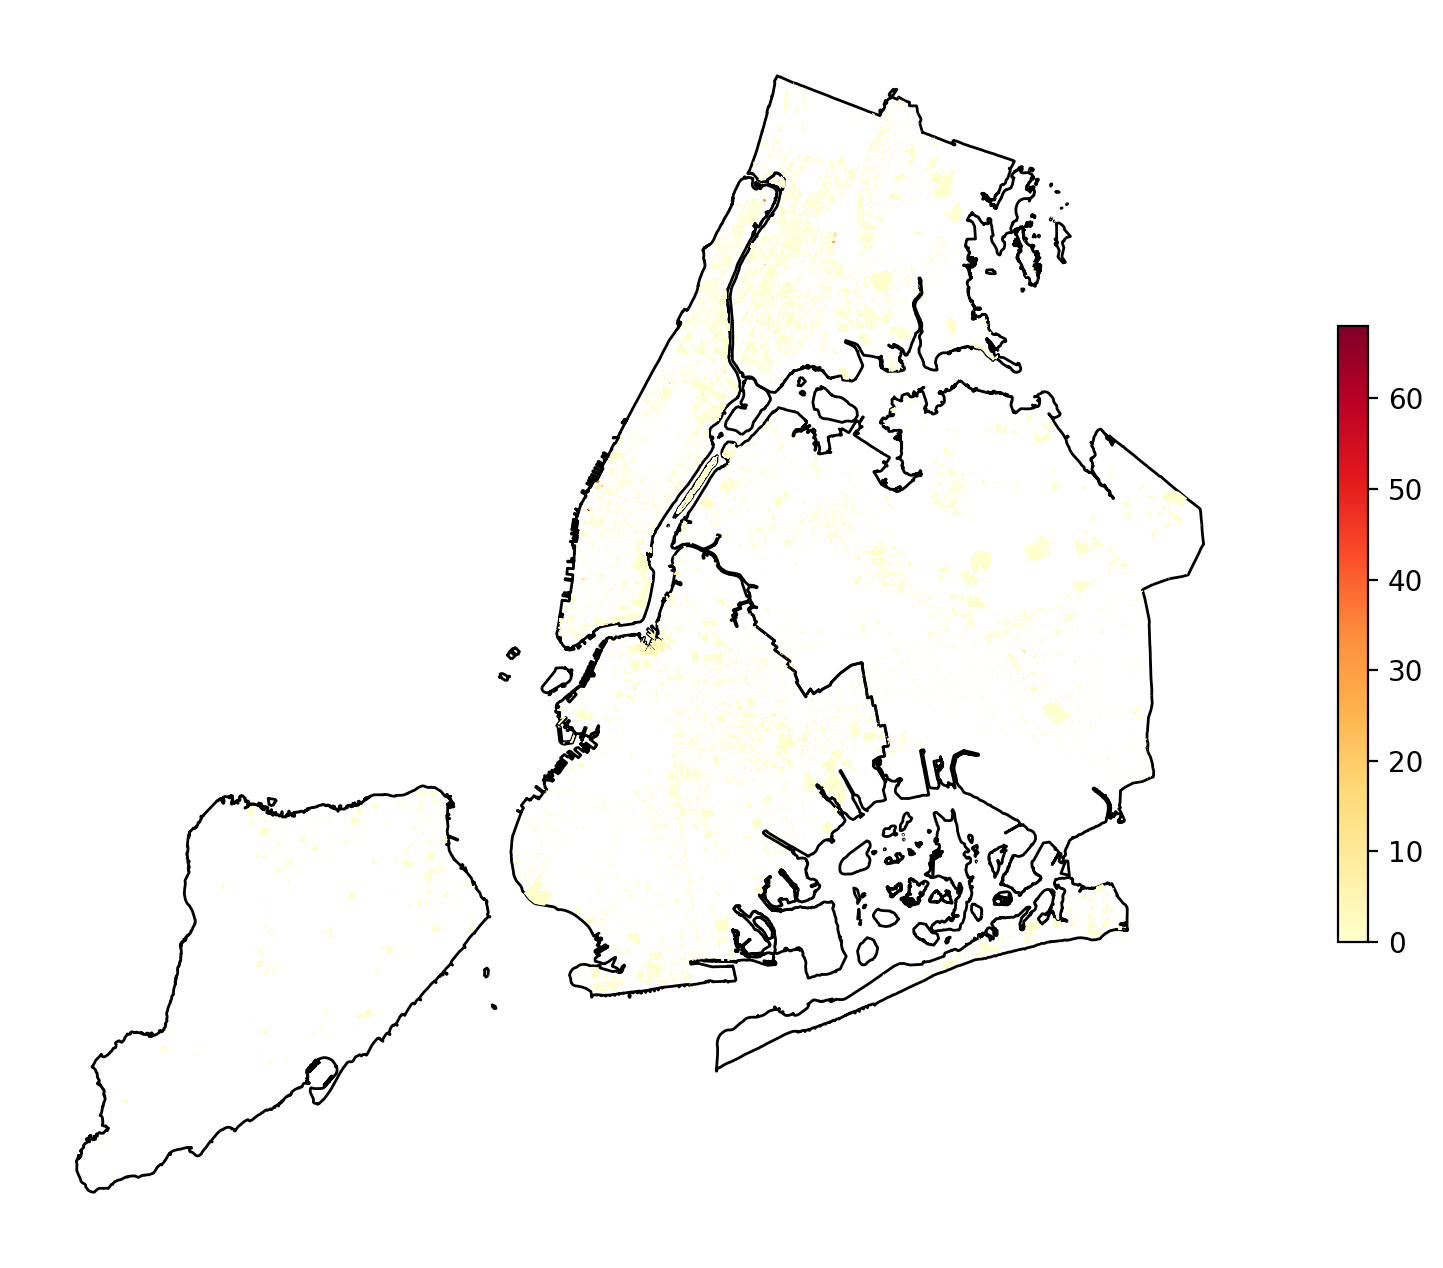

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
boros = gpd.read_file(
    "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson"
).to_crs(2263)
boros.plot(ax=ax, facecolor="none")
nyc_evictions_pluto.plot(
    ax=ax,
    column="eviction_rate_bldg",
    vmin=0,
    legend=True,
    cmap="YlOrRd",
    legend_kwds={"shrink": 0.4},
)
ax.set_axis_off()

Let's try visualizing this better. We'll drop extreme outliers, and we'll change the size of points based on the eviction rate. We'll also use the building centroid.

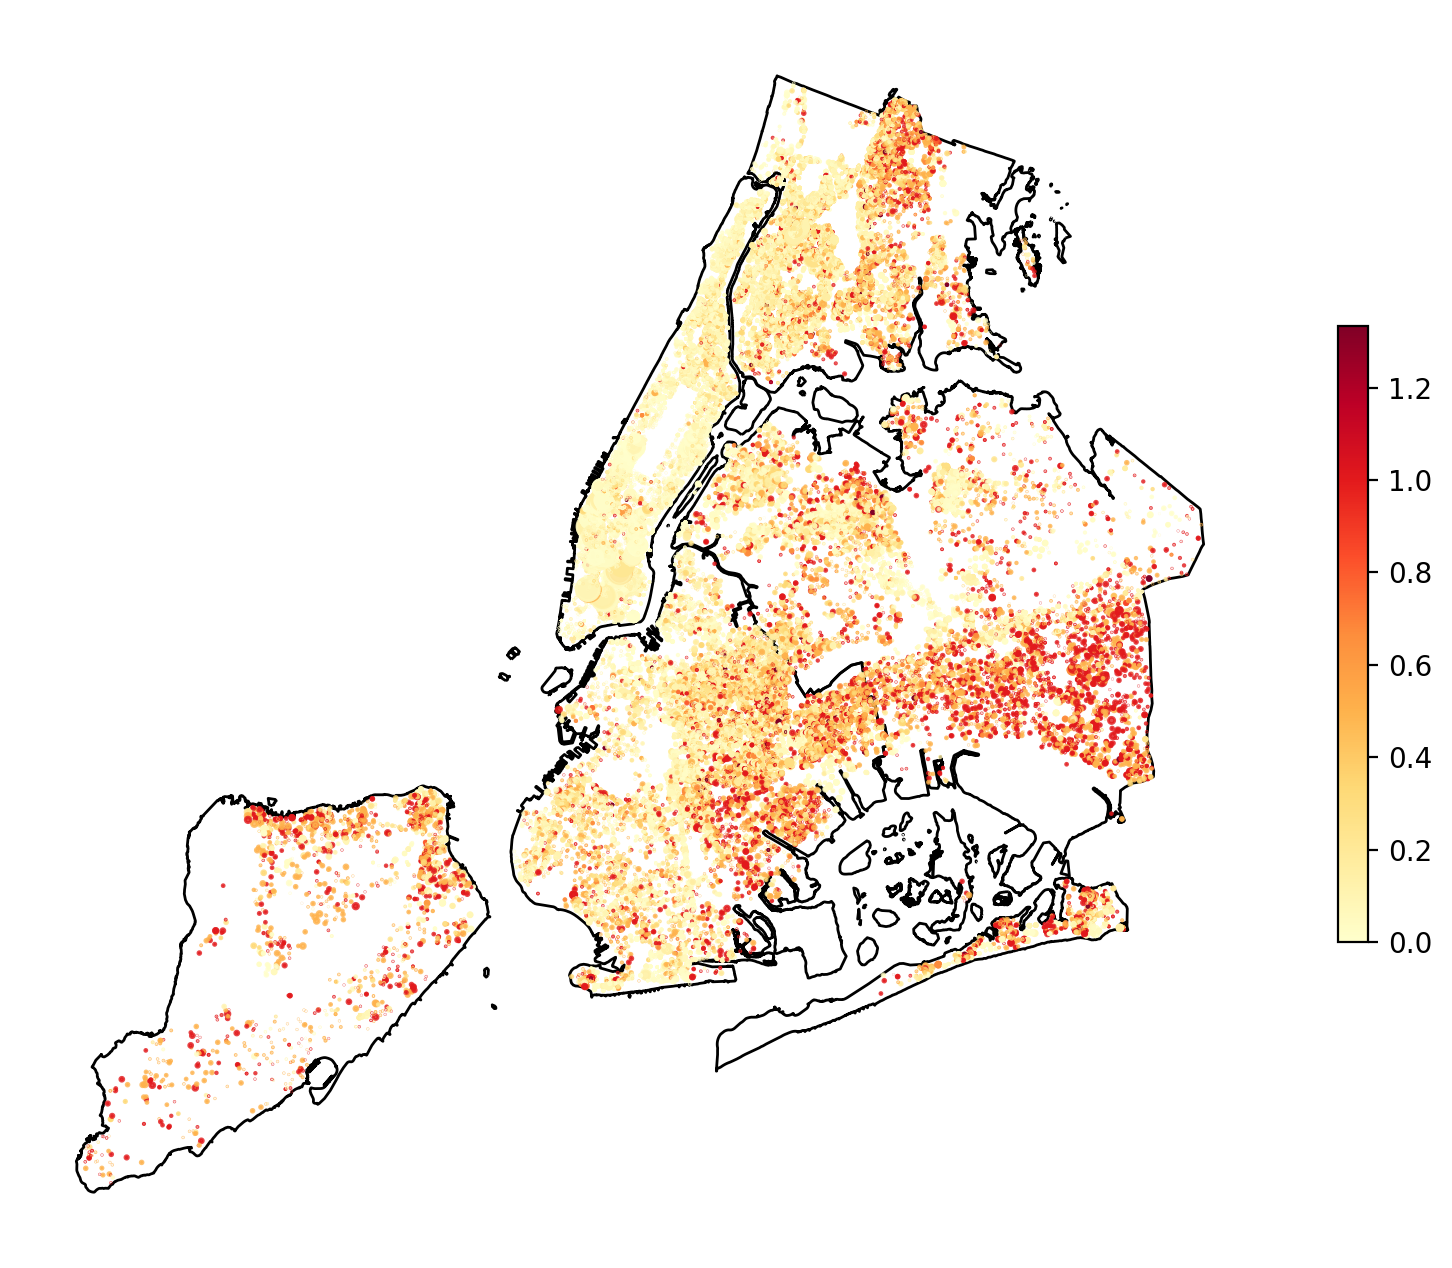

In [73]:
nyc_evictions_pluto["geometry"] = nyc_evictions_pluto["geometry"].centroid

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
boros.plot(ax=ax, facecolor="none")
nyc_evictions_pluto[
    nyc_evictions_pluto["eviction_rate_bldg"]
    <= nyc_evictions_pluto["eviction_rate_bldg"].quantile(0.95)
].plot(
    ax=ax,
    column="eviction_rate_bldg",
    markersize=nyc_evictions_pluto["eviction_rate_bldg"],
    vmin=0,
    alpha=0.8,
    legend=True,
    cmap="YlOrRd",
    legend_kwds={"shrink": 0.4},
)
ax.set_axis_off()

We can also make a heatmap using Folium.

In [ ]:
map = folium.Map(location=[40.7, -73.97], tiles="Cartodb dark_matter", zoom_start=10)
heat_data = [
    [point.xy[1][0], point.xy[0][0]]
    for point in nyc_evictions_pluto_centroid.to_crs(4326).geometry
]

folium.plugins.HeatMap(heat_data, radius=20, blur=20, min_opacity=0.2).add_to(
    map,
)
map